In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the data
data = pd.read_csv('/Users/xinyue/Desktop/Project 2/Other Regional.csv')
# Identify columns with dates and create new names
date_columns = [col for col in data.columns if "Unnamed" not in col]
new_columns = ['Region', 'Suburb']  # assuming the first two unnamed columns are region and suburb identifiers

# Loop through date columns and append Count and Median with respective date
for i, date in enumerate(date_columns):
    count_index = 2 * i + 83  # Adjust based on your specific pattern
    median_index = 2 * i + 85  # Adjust based on your specific pattern
    new_columns.append(f'Count {date}')
    new_columns.append(f'Median {date}')

# Set new column names to the DataFrame
data.columns = new_columns

# Save the DataFrame with new column names (optional)
# output_path = '/path_to_your_data/renamed_columns_data.csv'
# data.to_csv(output_path, index=False)

# Display the first few rows to check the new column names
print(data.head())


                   Region       Suburb Count Mar 2010 Median Mar 2010  \
0  Other Regional Centres   Bairnsdale            442         $220.00   
1                     NaN      Benalla            403         $200.00   
2                     NaN  Castlemaine            288         $225.00   
3                     NaN       Echuca            539         $220.00   
4                     NaN     Hamilton            348         $200.00   

  Count Jun 2010 Median Jun 2010 Count Sep 2010 Median Sep 2010  \
0            418         $220.00            410         $230.00   
1            421         $200.00            429         $200.00   
2            262         $235.00            270         $240.00   
3            551         $225.00            538         $230.00   
4            340         $200.00            349         $210.00   

  Count Dec 2010 Median Dec 2010  ... Count Mar 2019 Median Mar 2019  \
0            396         $240.00  ...            405         $300.00   
1            4

In [2]:
# Filtering and renaming columns that contain 'Median'
median_columns = [col for col in data.columns if 'Median' in col]

date_parts = [col.split(' ')[1:] for col in median_columns]  # This splits "Median Mar 2010" into ["Mar", "2010"]
dates = [' '.join(date) for date in date_parts]  # This joins them back to "Mar 2010"

# Rename columns to only have the date as the column name
data.rename(columns=dict(zip(median_columns, dates)), inplace=True)

# Include suburb and region columns
useful_columns = ['Region', 'Suburb'] + dates
data = data[useful_columns]
print(data)


                    Region                    Suburb Mar 2010 Jun 2010  \
0   Other Regional Centres                Bairnsdale  $220.00  $220.00   
1                      NaN                   Benalla  $200.00  $200.00   
2                      NaN               Castlemaine  $225.00  $235.00   
3                      NaN                    Echuca  $220.00  $225.00   
4                      NaN                  Hamilton  $200.00  $200.00   
5                      NaN                   Horsham  $185.00  $190.00   
6                      NaN                   Mildura  $200.00  $200.00   
7                      NaN            Moe-Newborough  $150.00  $160.00   
8                      NaN                   Morwell  $155.00  $160.00   
9                      NaN  Ocean Grove-Barwon Heads  $300.00  $300.00   
10                     NaN                  Portland  $200.00  $200.00   
11                     NaN               Sale-Maffra  $220.00  $220.00   
12                     NaN            

In [3]:
# Reshape the data
melted_data = data.melt(id_vars='Suburb', var_name='Date', value_name='Median Price')

# Convert 'Date' to datetime
melted_data['Date'] = pd.to_datetime(melted_data['Date'], format='%b %Y', errors='coerce')

# Sort data
melted_data.sort_values(by=['Suburb', 'Date'], inplace=True)
print(melted_data)

         Suburb       Date Median Price
22   Bairnsdale 2010-03-01      $220.00
44   Bairnsdale 2010-06-01      $220.00
66   Bairnsdale 2010-09-01      $230.00
88   Bairnsdale 2010-12-01      $240.00
110  Bairnsdale 2011-03-01      $240.00
..          ...        ...          ...
856     Wodonga 2019-06-01      $320.00
878     Wodonga 2019-09-01      $320.00
900     Wodonga 2019-12-01      $325.00
922     Wodonga 2023-03-01      $410.00
20      Wodonga        NaT          NaN

[924 rows x 3 columns]


In [4]:
# Convert all median price columns to floats and handle potential formatting issues
for col in data.columns[2:]:  # Assuming the first two columns are 'Region' and 'Suburb'
    data[col] = pd.to_numeric(data[col].str.replace('$', '').replace(',', ''), errors='coerce')

# Reshape the data
melted_data = data.melt(id_vars=['Suburb'], var_name='Date', value_name='Median Price')

# Convert 'Date' to datetime
melted_data['Date'] = pd.to_datetime(melted_data['Date'], format='%b %Y', errors='coerce')

# Remove any rows with missing data, particularly in 'Date' or 'Median Price'
melted_data.dropna(subset=['Date', 'Median Price'], inplace=True)

# Ensure 'Median Price' is a float
melted_data['Median Price'] = melted_data['Median Price'].astype(float)
print(melted_data)

          Suburb       Date  Median Price
22    Bairnsdale 2010-03-01         220.0
23       Benalla 2010-03-01         200.0
24   Castlemaine 2010-03-01         225.0
25        Echuca 2010-03-01         220.0
26      Hamilton 2010-03-01         200.0
..           ...        ...           ...
919  Wanagaratta 2023-03-01         380.0
920     Warragul 2023-03-01         440.0
921  Warrnambool 2023-03-01         420.0
922      Wodonga 2023-03-01         410.0
923  Group Total 2023-03-01         390.0

[902 rows x 3 columns]


In [5]:
# Ensure 'Median Price' is a float
melted_data['Median Price'] = melted_data['Median Price'].astype(float)


# Generate future 3 years growth rates using ARIMA model 

Processing Bairnsdale


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

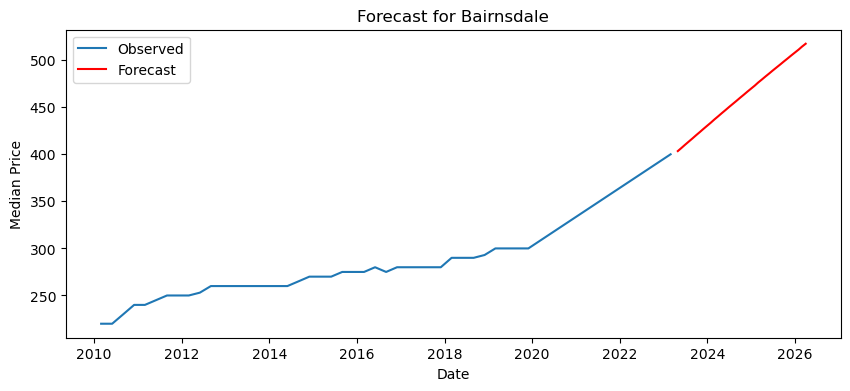

Processing Benalla


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

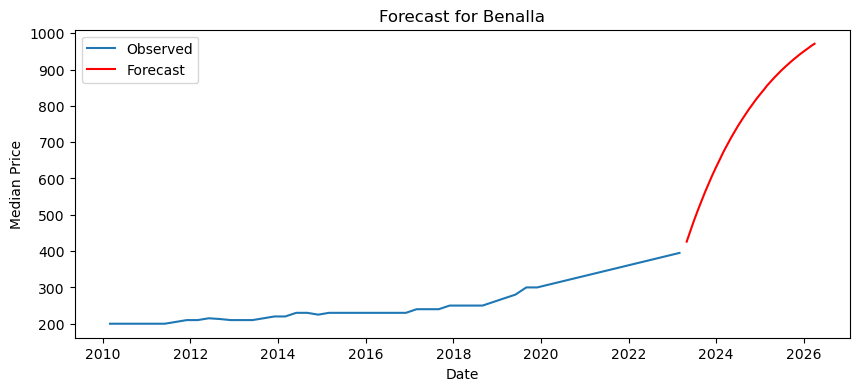

Processing Castlemaine


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

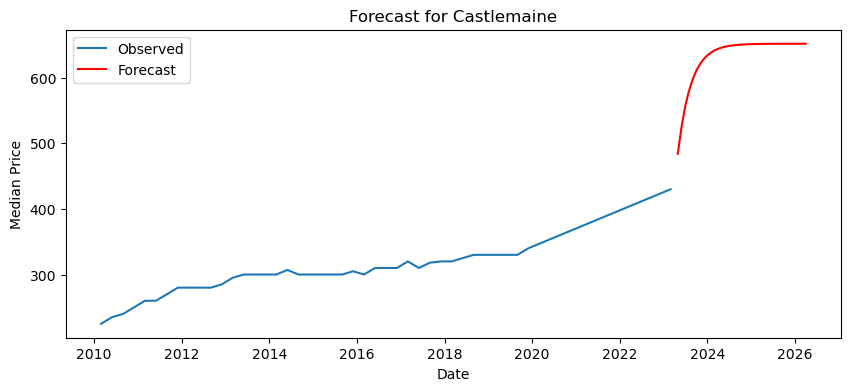

Processing Echuca


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

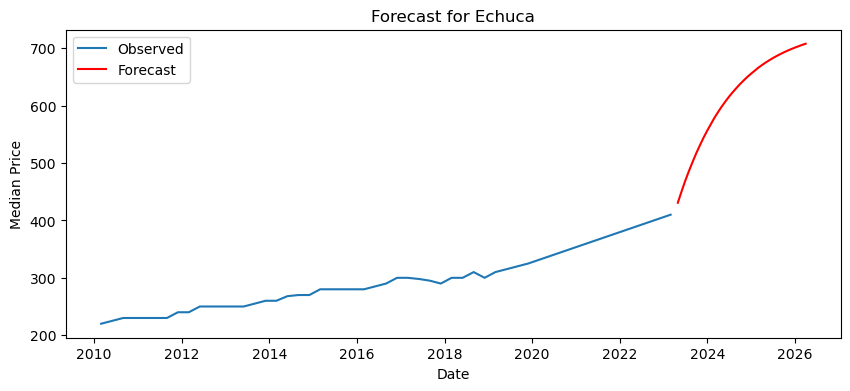

Processing Group Total


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

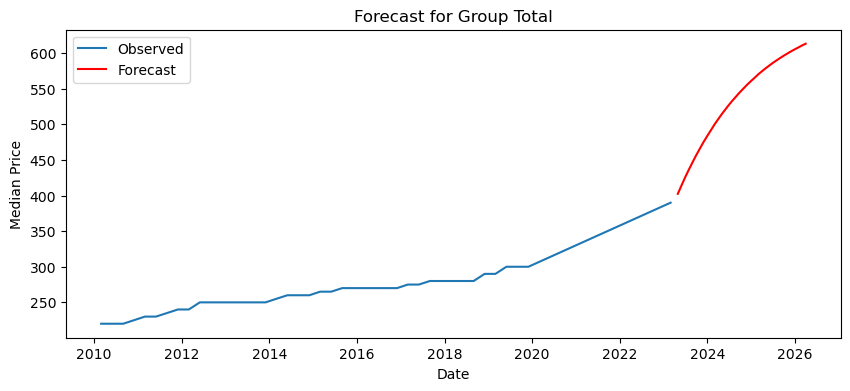

Processing Hamilton


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

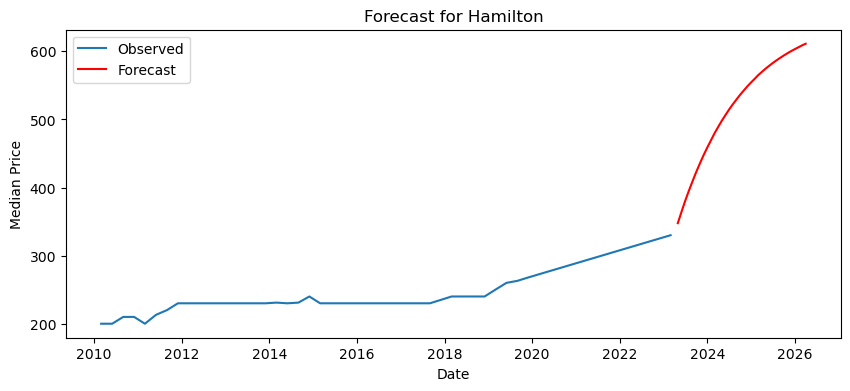

Processing Horsham


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/xinyue/opt/a

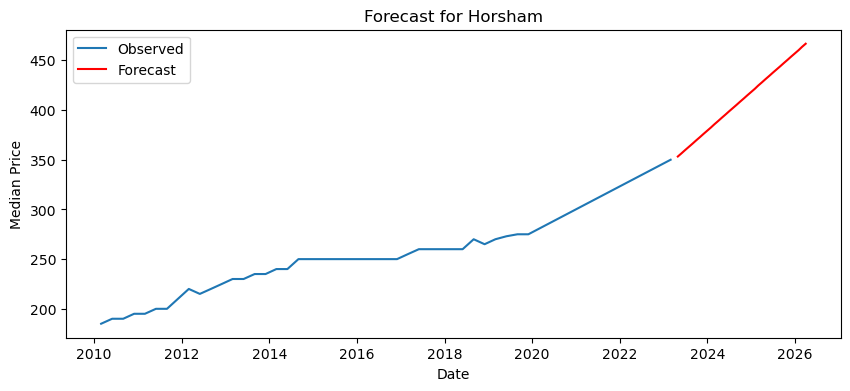

Processing Mildura


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

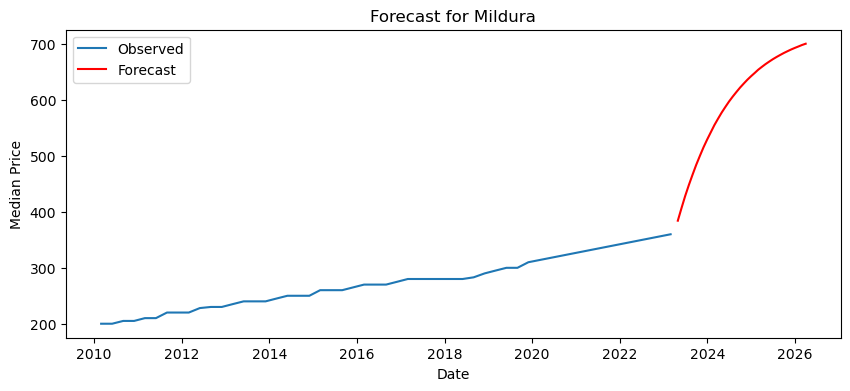

Processing Moe-Newborough


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

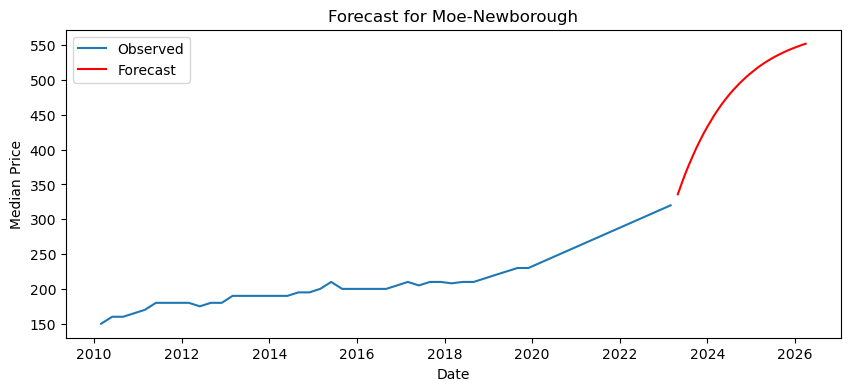

Processing Morwell


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

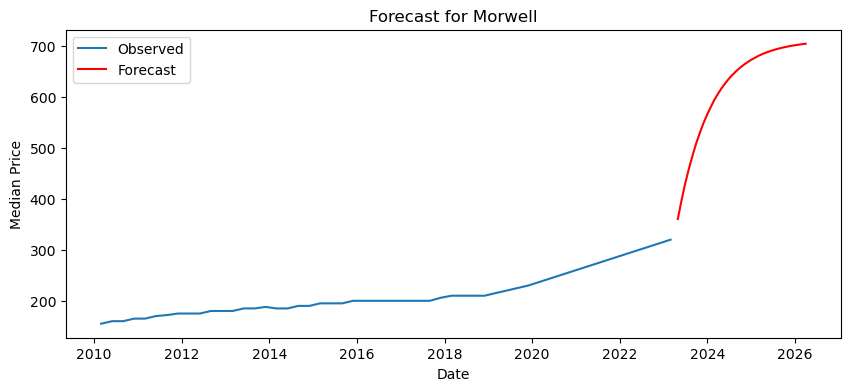

Processing Ocean Grove-Barwon Heads


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

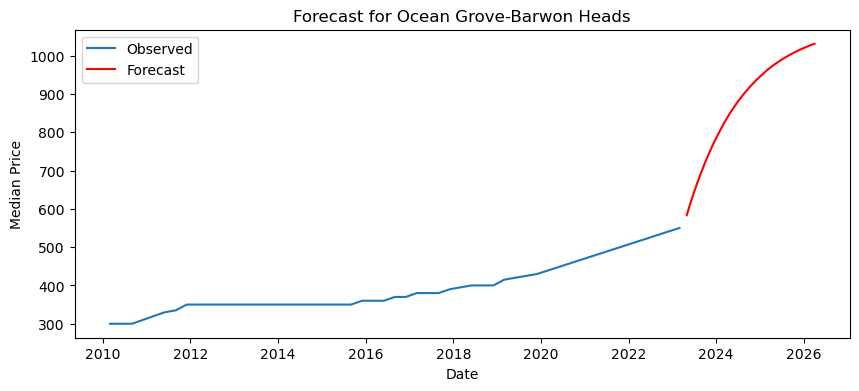

Processing Portland


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

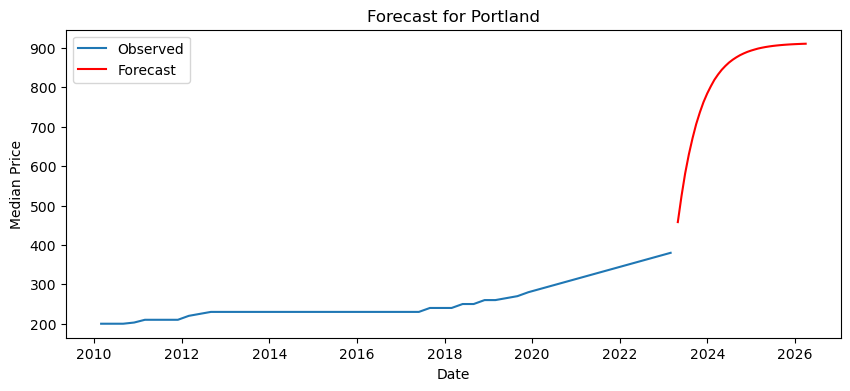

Processing Sale-Maffra


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

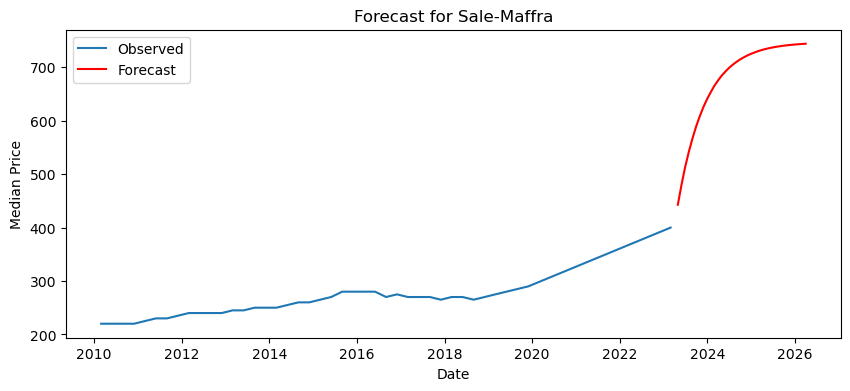

Processing Seymour


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

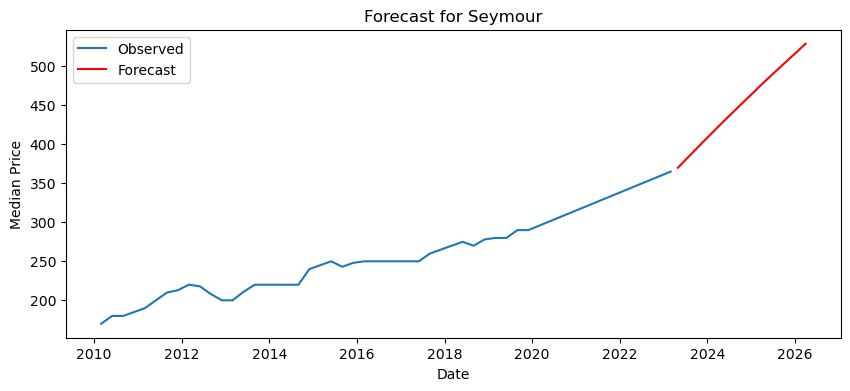

Processing Shepparton


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

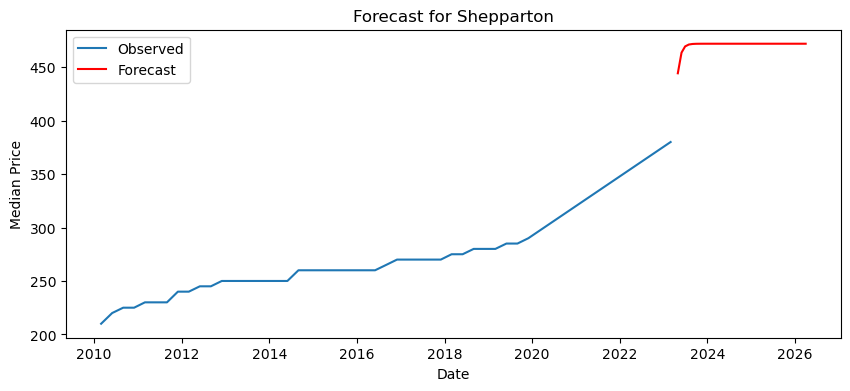

Processing Swan Hill


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

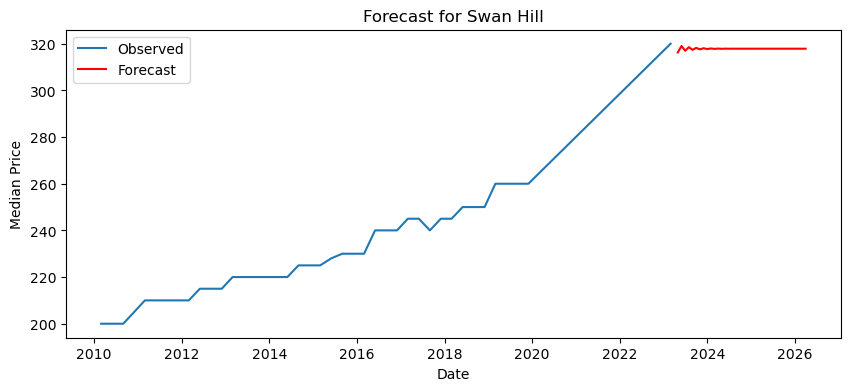

Processing Torquay


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/xinyue/opt/a

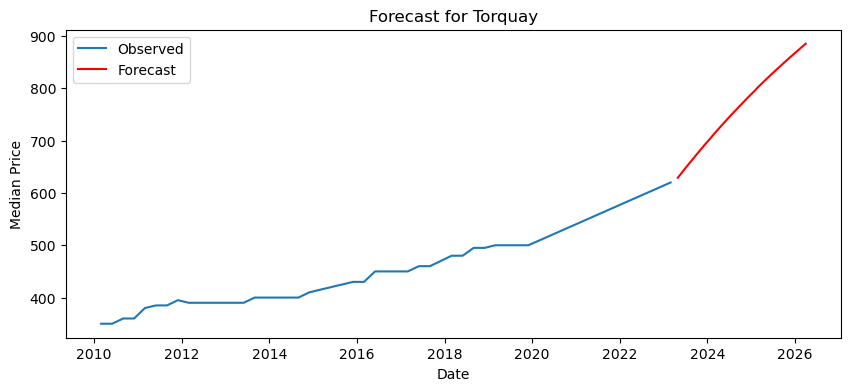

Processing Traralgon


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

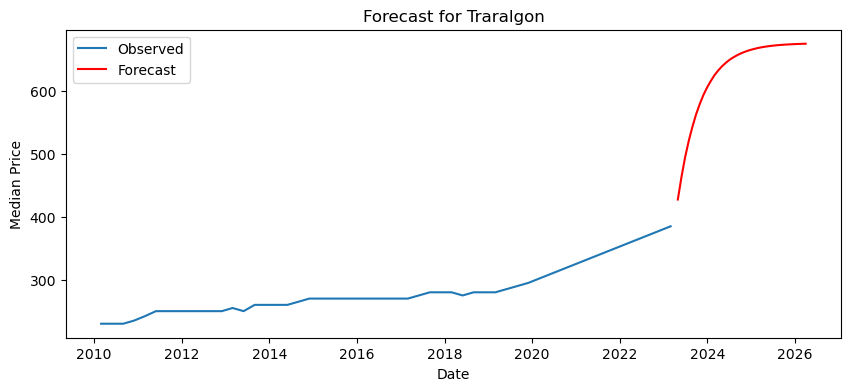

Processing Wanagaratta


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

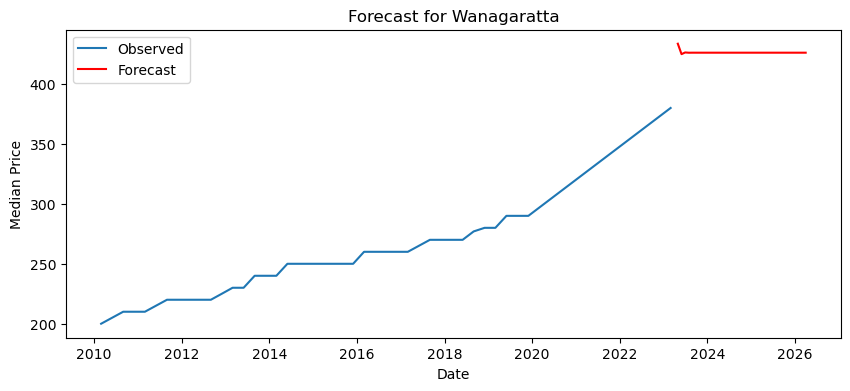

Processing Warragul


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

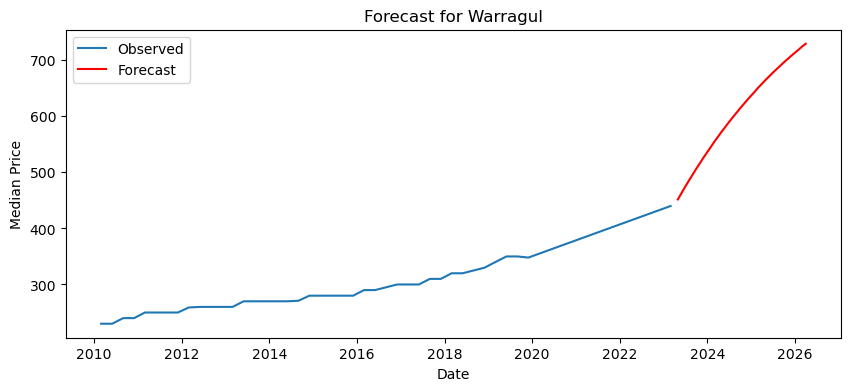

Processing Warrnambool


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

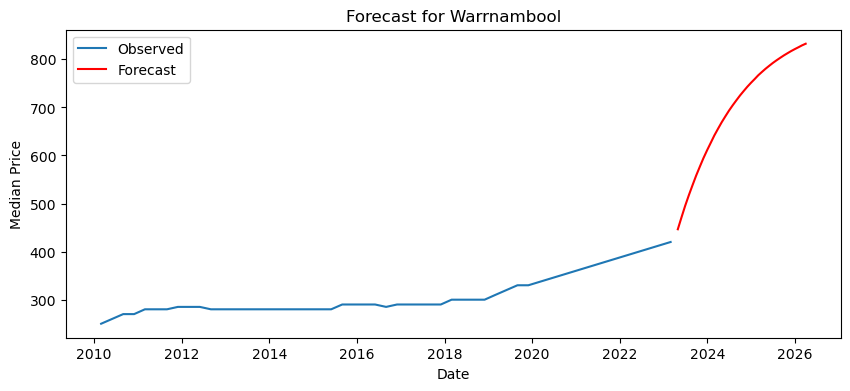

Processing Wodonga


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

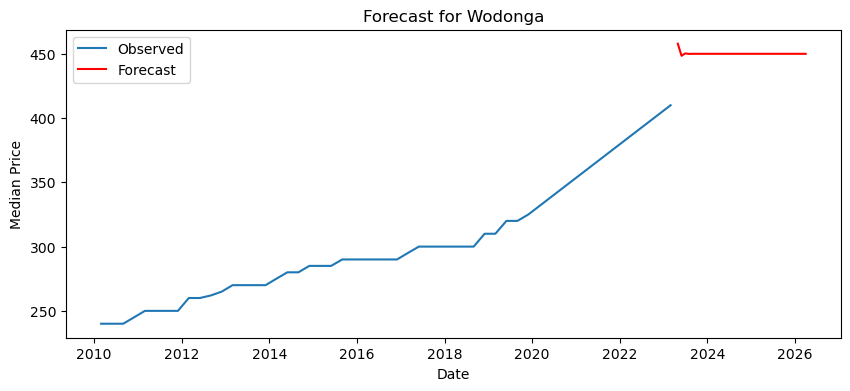

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

grouped = melted_data.groupby('Suburb')

# Loop through each suburb
for suburb, group in grouped:
    print(f"Processing {suburb}")
    try:
        # Ensure there are enough data points to model
        if len(group) > 20:
            # Ensure the data is sorted by date
            group = group.sort_values(by='Date')
            
            # Fit ARIMA model (consider optimizing the order based on ACF/PACF plots)
            model = ARIMA(group['Median Price'], order=(1,1,1))
            model_fit = model.fit()
            
            # Forecasting for the next 36 months (3 years)
            forecast = model_fit.forecast(steps=36)
            
            # Plotting
            plt.figure(figsize=(10, 4))
            plt.plot(group['Date'], group['Median Price'], label='Observed')
            future_dates = pd.date_range(start=group['Date'].iloc[-1], periods=37, freq='M')[1:]
            plt.plot(future_dates, forecast, label='Forecast', color='red')
            plt.title(f"Forecast for {suburb}")
            plt.xlabel('Date')
            plt.ylabel('Median Price')
            plt.legend()
            plt.show()
            
    except Exception as e:
        print(f"Failed to fit model for {suburb}: {e}")

# Training ARIMA model base on data from 2010 to 2016 and testing the data from 2017 to 2019 and 2023. 

Processing Bairnsdale


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/xinyue/opt/a

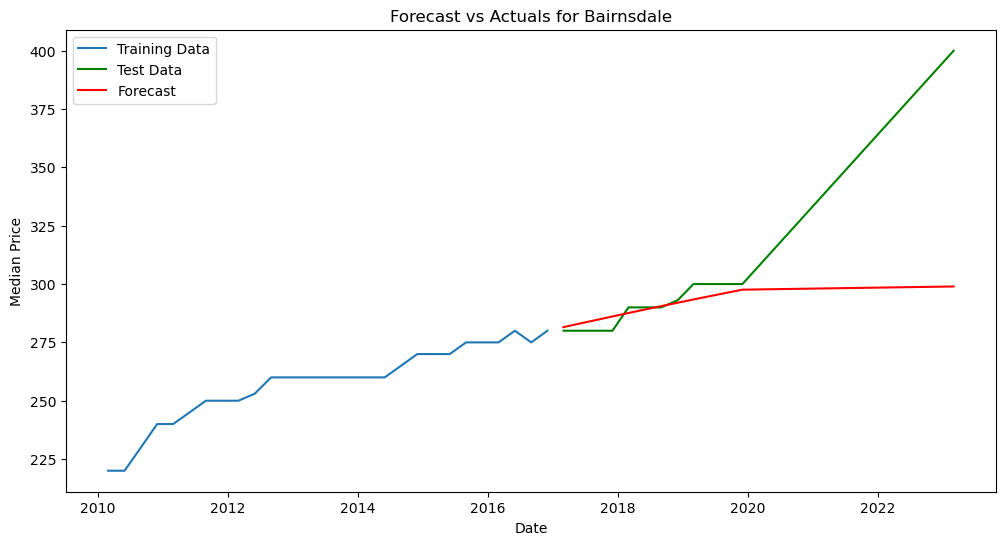

Processing Benalla


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

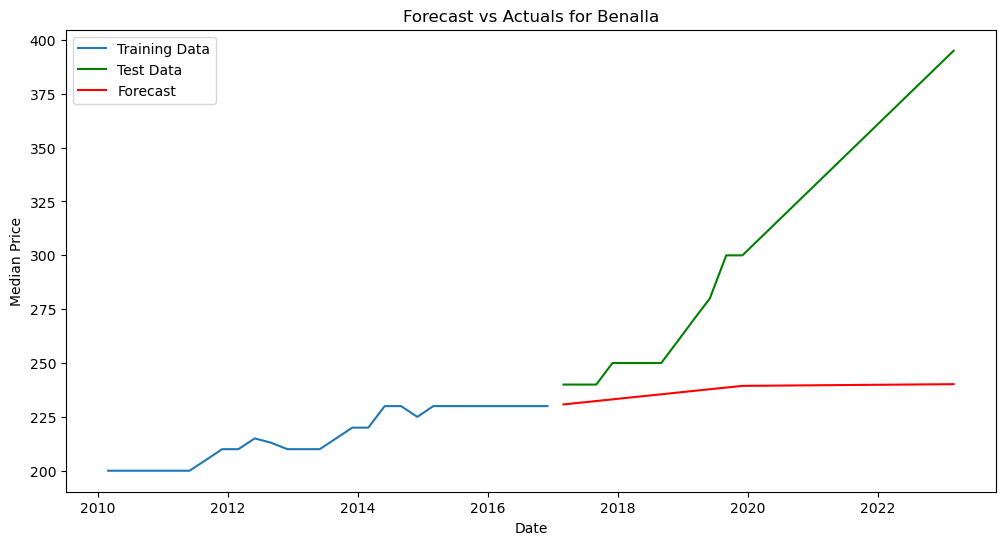

Processing Castlemaine


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

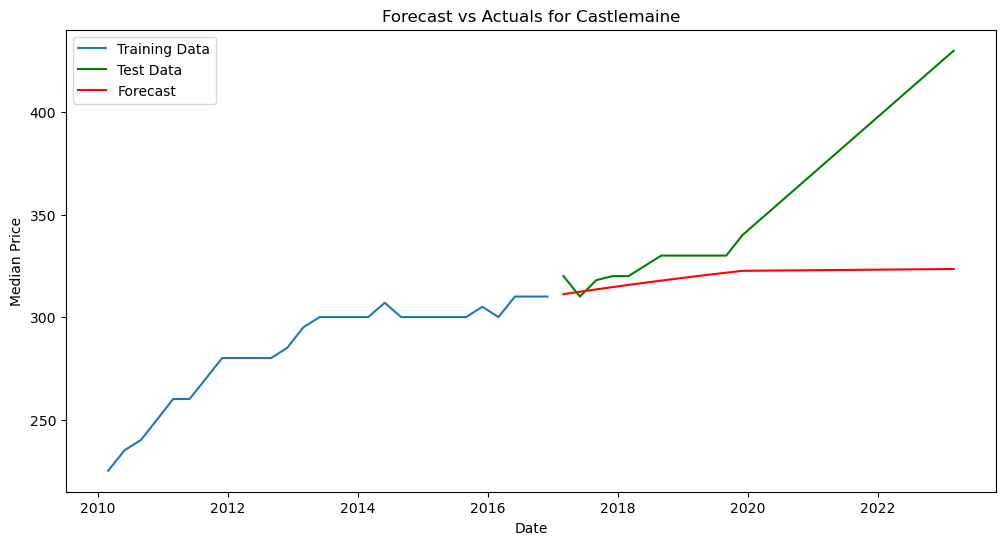

Processing Echuca


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/xinyue/opt/anaconda3/

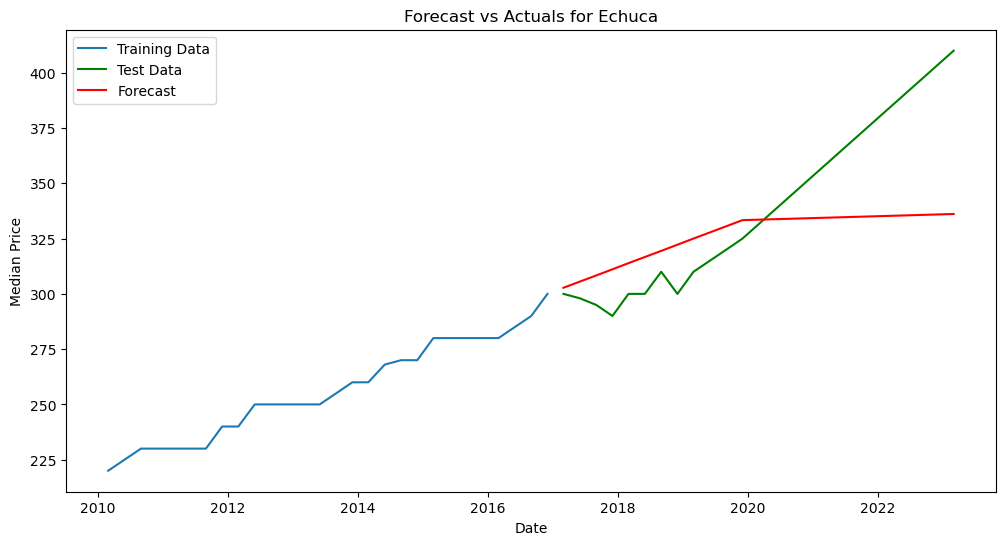

Processing Group Total


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

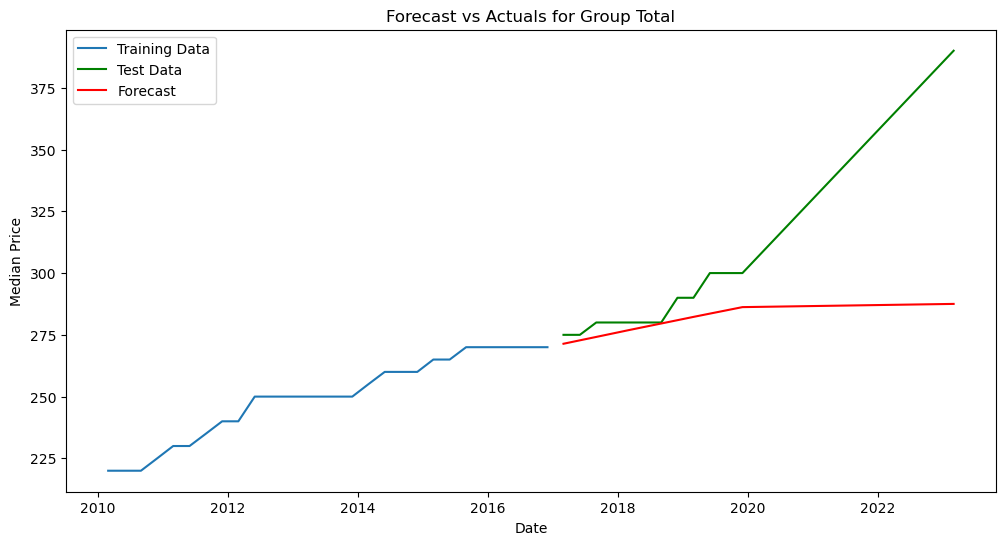

Processing Hamilton


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

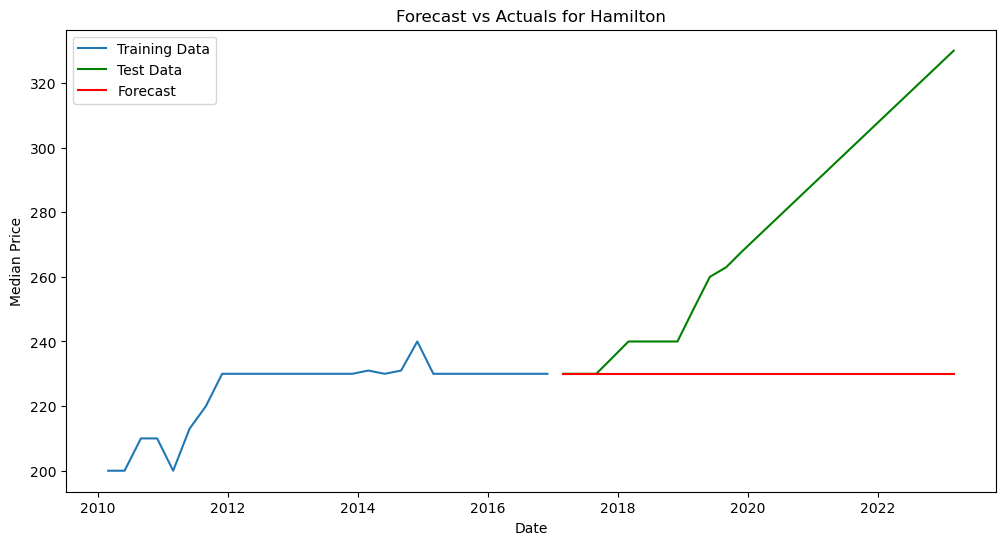

Processing Horsham


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

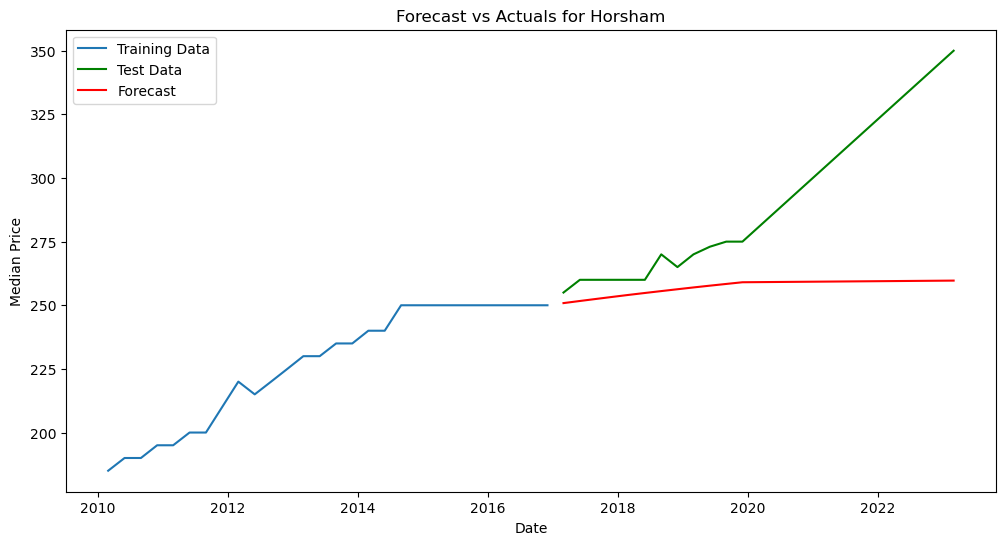

Processing Mildura


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

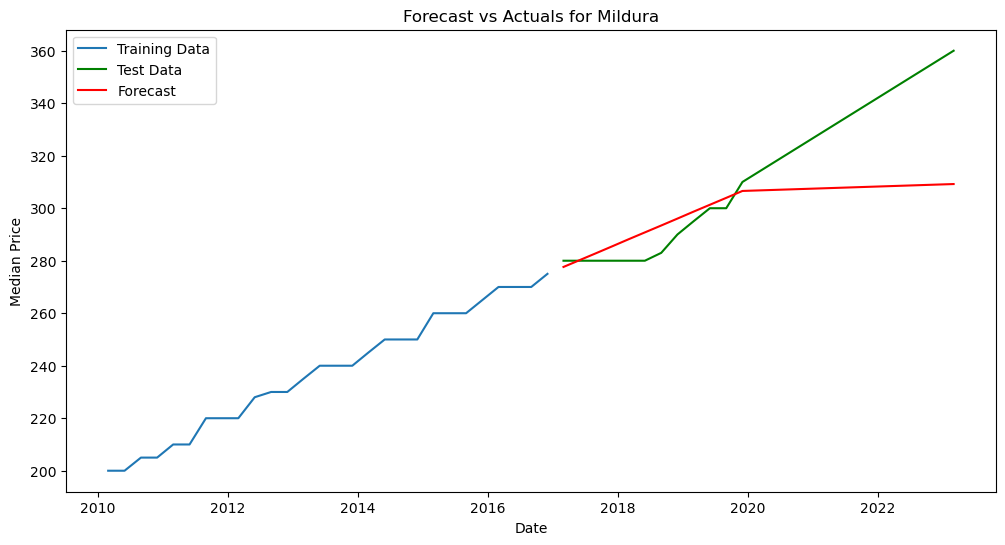

Processing Moe-Newborough


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/xinyue/opt/anaconda3/

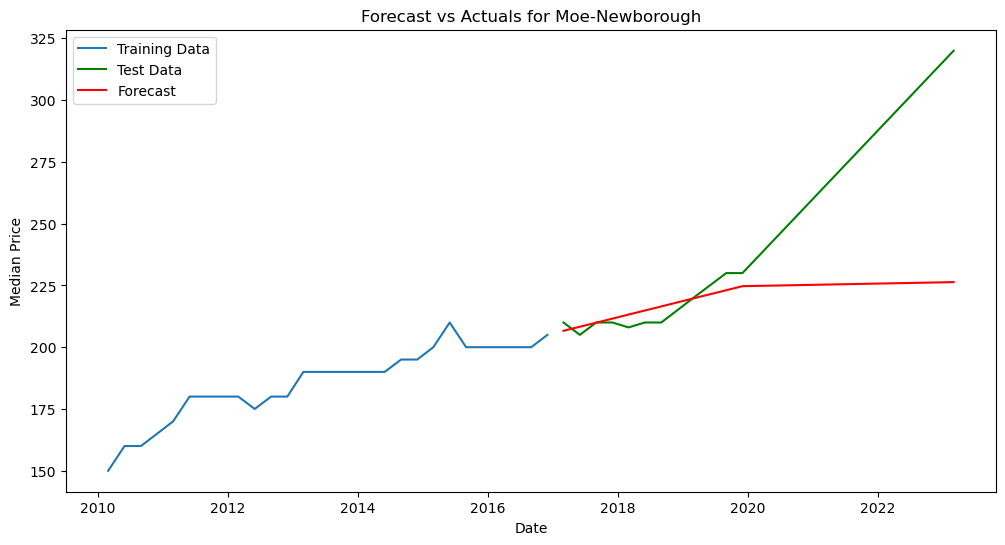

Processing Morwell


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/xinyue/opt/a

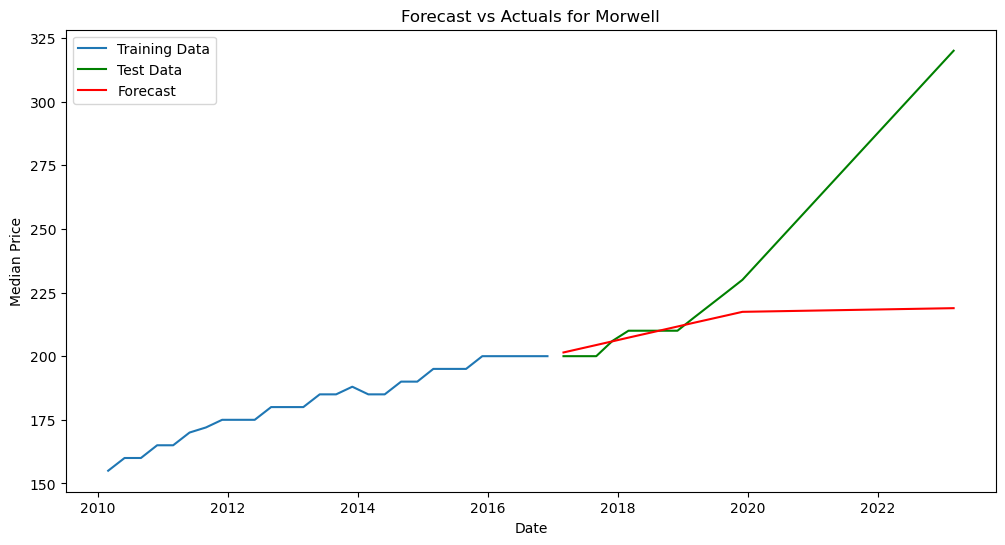

Processing Ocean Grove-Barwon Heads


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

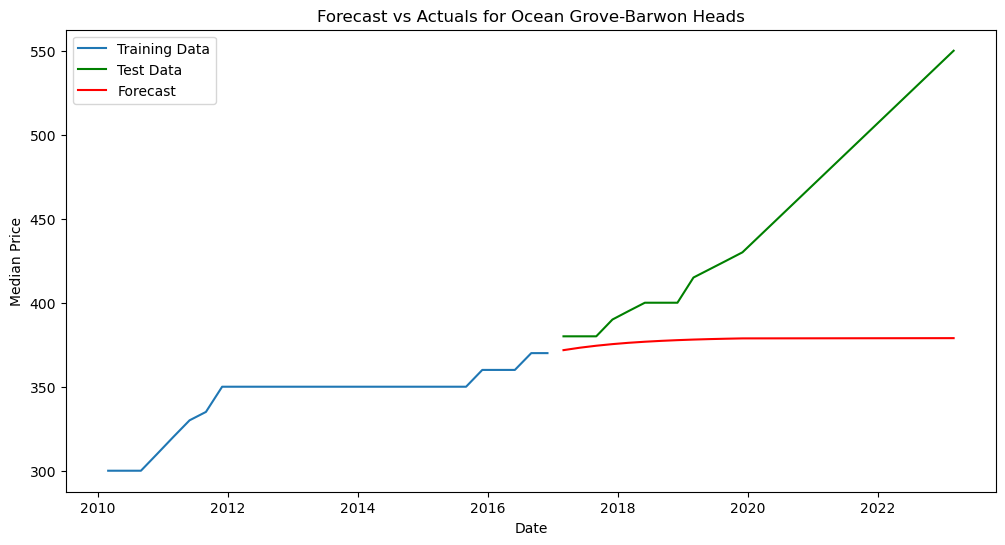

Processing Portland


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

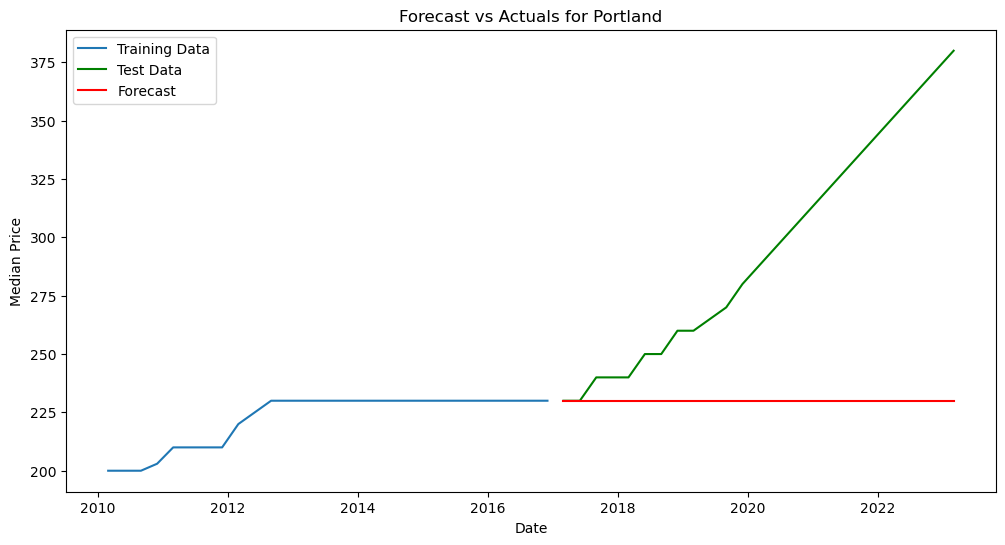

Processing Sale-Maffra


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

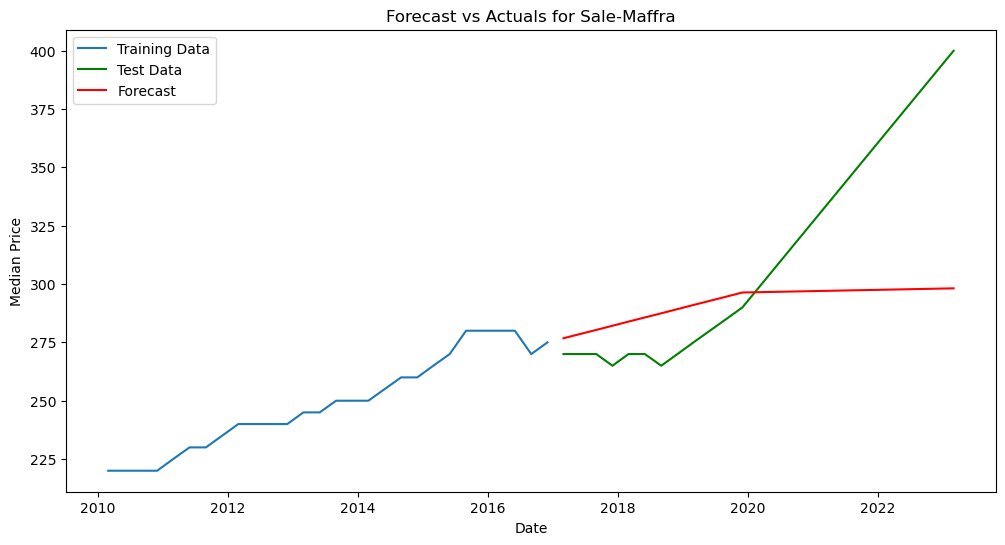

Processing Seymour


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

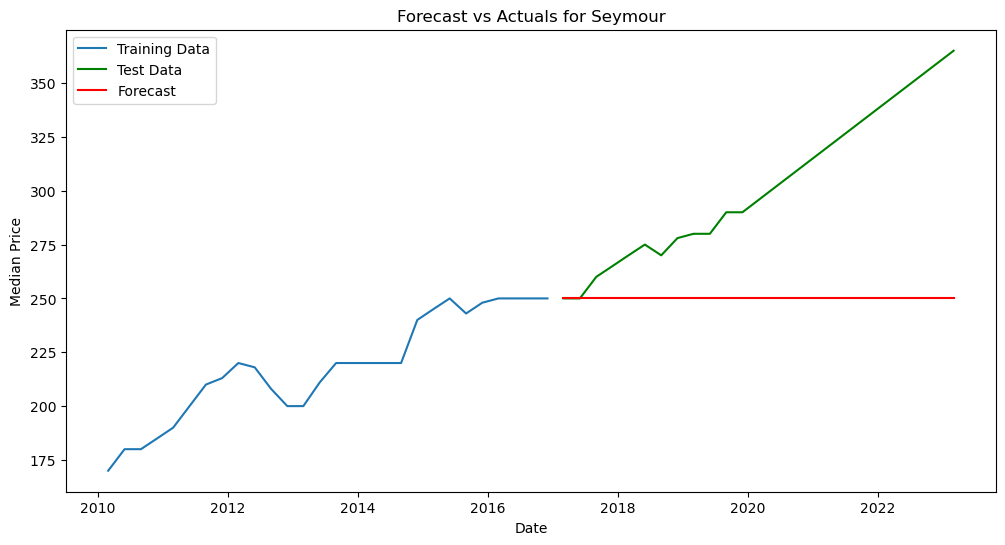

Processing Shepparton


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

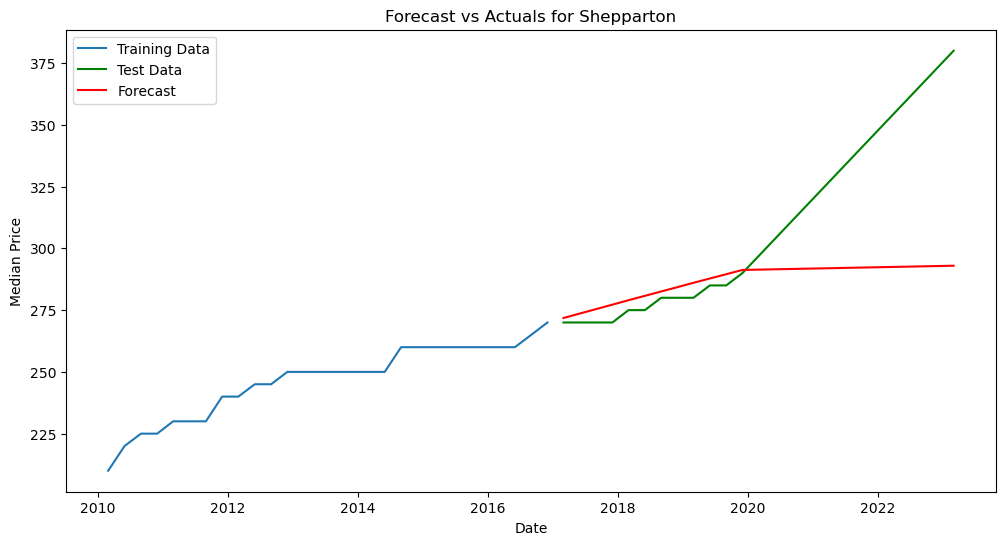

Processing Swan Hill


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

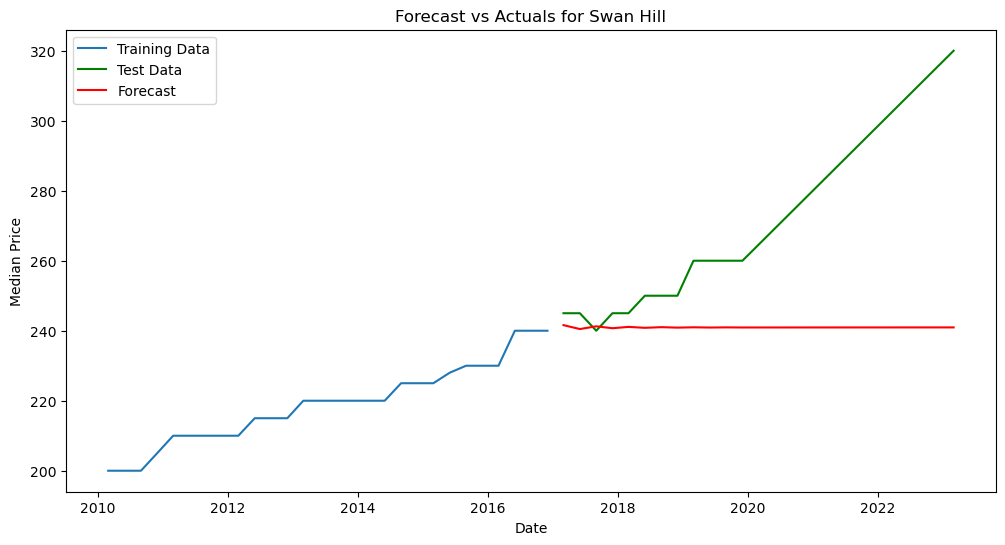

Processing Torquay


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

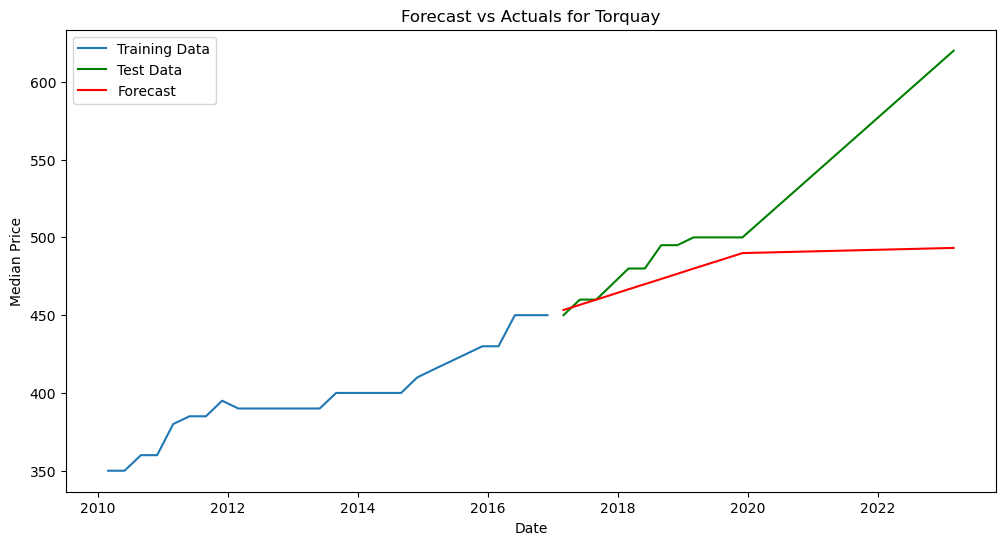

Processing Traralgon


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

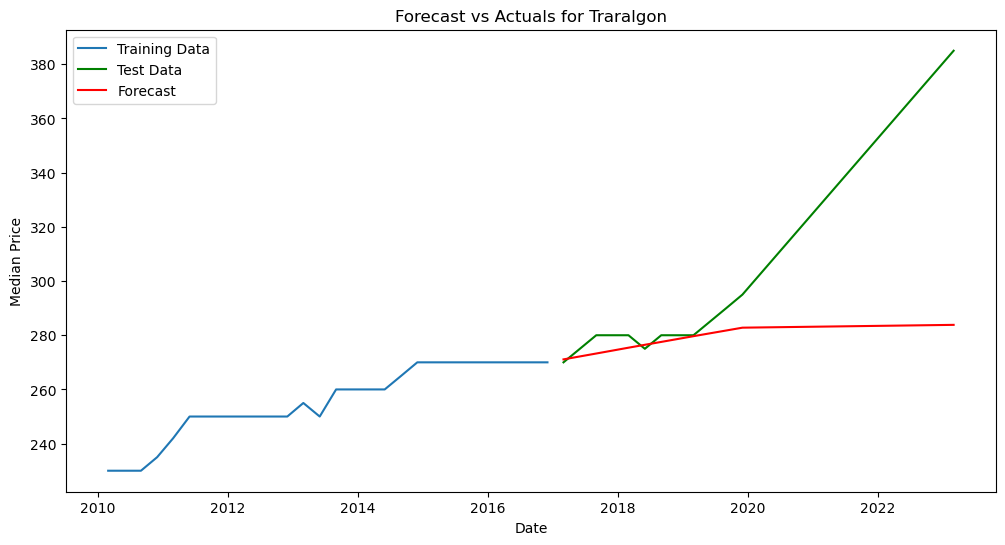

Processing Wanagaratta


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

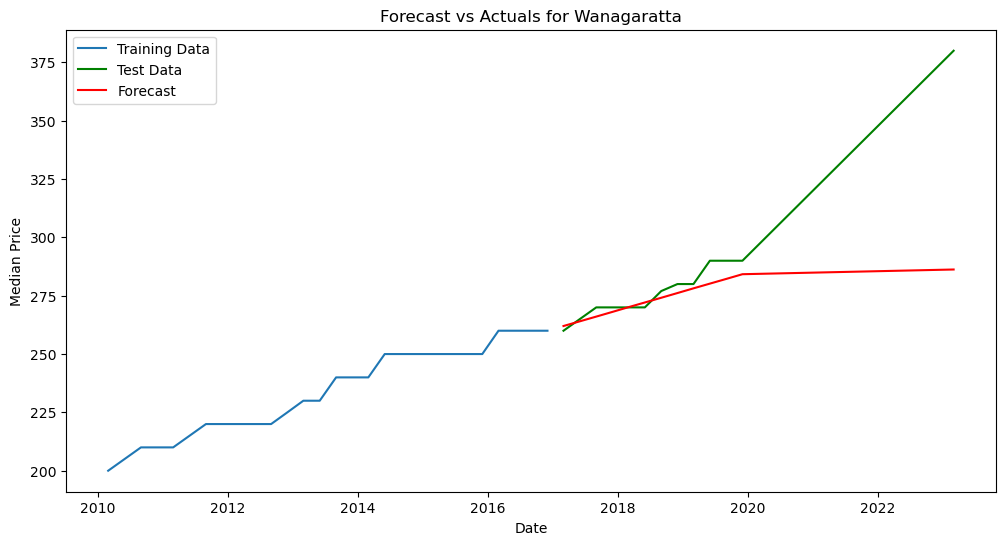

Processing Warragul


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

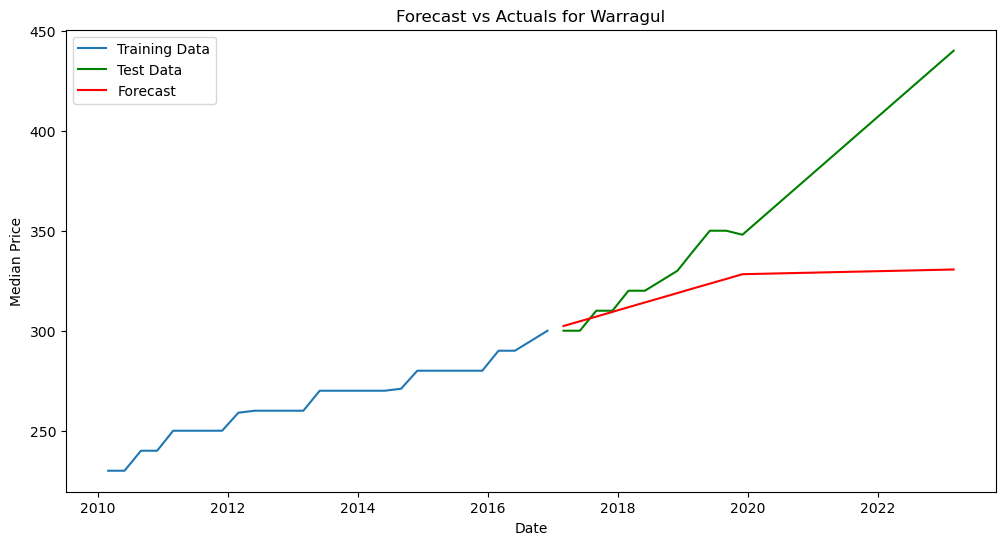

Processing Warrnambool


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

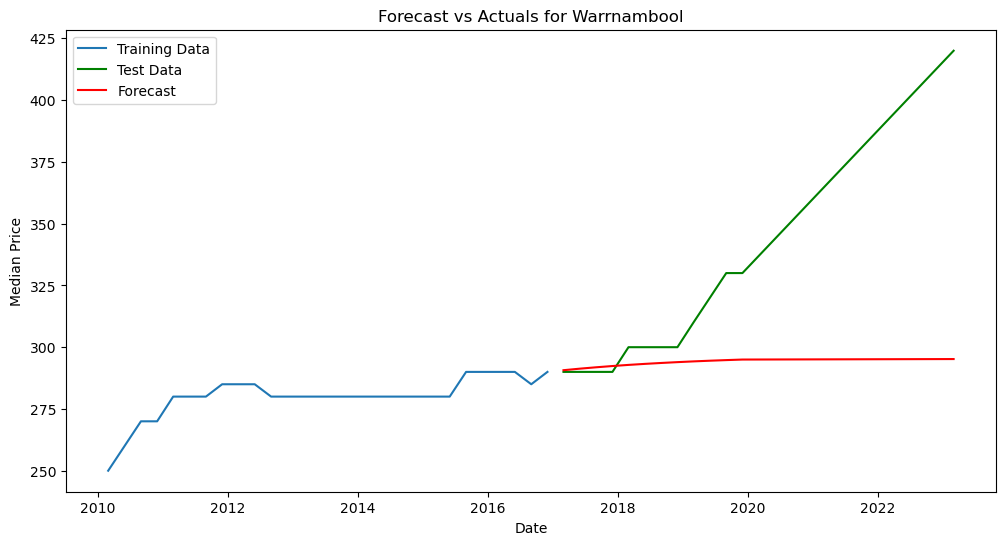

Processing Wodonga


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

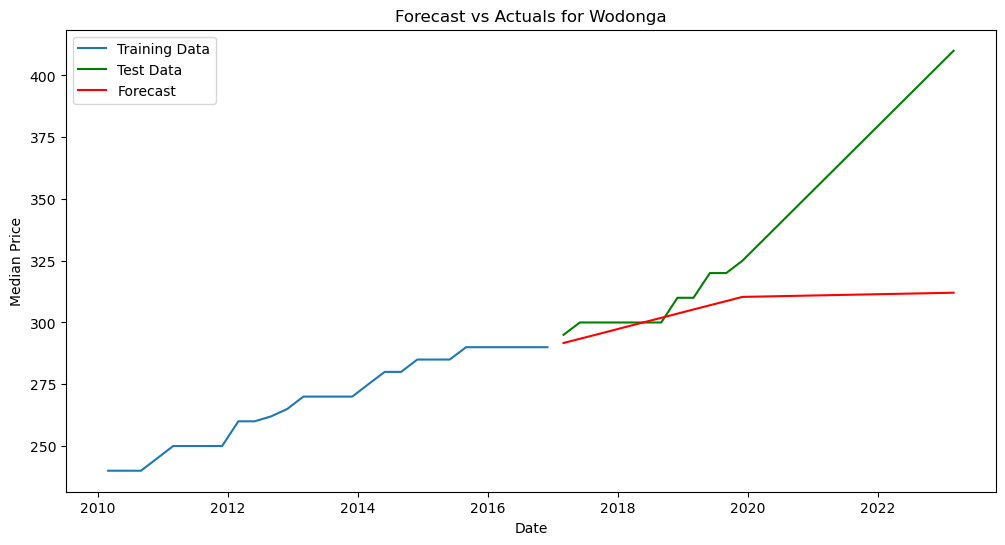

Top 10 Suburbs with the Highest Predicted Growth Rates:
Mildura: 11.37%
Echuca: 11.02%
Moe-Newborough: 9.53%
Warragul: 9.35%
Wanagaratta: 9.24%
Torquay: 8.80%
Morwell: 8.64%
Shepparton: 7.78%
Sale-Maffra: 7.72%
Wodonga: 6.98%


In [7]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Group data by suburb
grouped = melted_data.groupby('Suburb')

# Dictionary to hold the last actual median price and the last forecasted price
growth_rates = {}

for suburb, group in grouped:
    print(f"Processing {suburb}")
    try:
        # Splitting the data based on date
        train = group[group['Date'] <= pd.Timestamp('2016-12-31')]
        test = group[group['Date'] > pd.Timestamp('2016-12-31')]

        # Ensure there are enough data points to model
        if len(train) > 20:
            model = ARIMA(train['Median Price'], order=(1,1,1))  # Basic ARIMA model
            model_fit = model.fit()

            # Forecast
            forecast_steps = len(test)  # Dynamically determine how many steps to forecast based on available test data
            forecast = model_fit.forecast(steps=forecast_steps)

            # Plotting
            plt.figure(figsize=(12, 6))
            plt.plot(train['Date'], train['Median Price'], label='Training Data')
            plt.plot(test['Date'], test['Median Price'], label='Test Data', color='green')
            plt.plot(test['Date'], forecast, label='Forecast', color='red')
            plt.title(f"Forecast vs Actuals for {suburb}")
            plt.xlabel('Date')
            plt.ylabel('Median Price')
            plt.legend()
            plt.show()

            # Calculate predicted growth rate
            if len(forecast) > 0 and len(test) > 0:
                predicted_last = forecast.iloc[-1]
                last_actual = forecast.iloc[0]
                predicted_growth_rate = ((predicted_last - last_actual) / last_actual) * 100
                growth_rates[suburb] = predicted_growth_rate

        else:
            print(f"Not enough data points to train ARIMA model for {suburb}")

    except Exception as e:
        print(f"Failed to fit model for {suburb}: {e}")

# Now, let's print the top 10 suburbs with the highest predicted growth rates
top_10_suburbs = sorted(growth_rates, key=growth_rates.get, reverse=True)[:10]
print("Top 10 Suburbs with the Highest Predicted Growth Rates:")
for suburb in top_10_suburbs:
    print(f"{suburb}: {growth_rates[suburb]:.2f}%")



In [8]:
train = melted_data['Median Price'][:int(0.8 * len(data))]
test = melted_data['Median Price'][int(0.8 * len(data)):]

In [9]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1,1,1))  # Example: ARIMA model
model_fit = model.fit()


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
forecast = model_fit.forecast(steps=len(test))


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(actual, predicted):
    """
    Calculate and return the evaluation metrics for the model.
    
    Parameters:
        actual (array-like): The actual observed values.
        predicted (array-like): The forecasted values from the model.
    
    Returns:
        dict: A dictionary containing MAE, MSE, RMSE, and MAPE.
    """
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # Handle cases where actual values are zero
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Assume 'test' is your actual data and 'forecast' is the data predicted by the model
metrics = calculate_metrics(test, forecast)

print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {metrics['MAE']}")
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']}")
print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']}%")


Evaluation Metrics:
Mean Absolute Error (MAE): 54.77186905518595
Root Mean Squared Error (RMSE): 76.53549911008467
Mean Absolute Percentage Error (MAPE): 17.42253101362106%
